In [636]:
#import tensorflow as tf
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import chi2
from math import floor
from joblib import Parallel, delayed
from sklearn.svm import LinearSVC
import random
import os
from sklearn.metrics import precision_recall_fscore_support as full_score
from sklearn.model_selection import train_test_split
%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [ ]:
def ExistDseparator(TargetNode,Xi, Z, X, alpha):
    flagExist = False
    dsepSet=[]
    #counter=0
    #print_names(Z)
    for i in range(0,(2**len(Z))-1):
        IDsubsetZ_dec = i
        IDsubsetZ_bin = bin(IDsubsetZ_dec)
        subsetZ = getZsubset(IDsubsetZ_bin,Z)
        # no cache
        #print("from exist dseparator")
        dep = Dep(TargetNode,Xi,subsetZ, X, alpha)
        #print(subsetZ)
        #print(dep)
        if (dep==0):
            flagExist = True
            dsepSet = subsetZ
            break
    #print("Module exist d-separator: ",counter)
    return [flagExist,dsepSet]

In [ ]:
def GetCondValues(z, condVars):
    if len(condVars)>1:
        maxz = 1
        for column in condVars:
            maxz*=int(column['name'].split('@')[1]) # equals to prod(sizes)
        d = np.zeros(len(condVars))
        
        div_dim = maxz/int(condVars[0]['name'].split('@')[1])
        num2div = z
        
        for i in range(0,len(condVars)-1):
            d[i] = floor(num2div/div_dim)
            num2div=num2div%div_dim
            div_dim = div_dim/int(condVars[i+1]['name'].split('@')[1])
        d[i] = num2div
    else:
        d = [z]
#     print("Size of condVars was: "+str(len(condVars)))
#     print(d)
#     print(sum([],d))
#     if (len(d)>1):
#         print(d)
#         print(z)
#         print_names(condVars)
    return d

In [ ]:
def Dep(TargetNode, Xi, CondVars, X, alpha):
    #print('in Dep')
    global data_c_size
    
    vvTarget = []
    for i in range(int(TargetNode['name'].split('@')[1])):
        vvTarget.append(i)
    
    vvXi = []
    for i in range(int(Xi['name'].split('@')[1])):
        vvXi.append(i)
    
    szCondVars = 1
    #print(CondVars)
    for column in CondVars:
        #print(column)
        szCondVars *= int(column['name'].split('@')[1])
    
    if data_c_size <= (5 * len(vvTarget)*len(vvXi)*(szCondVars)):
        return 1
    
    if (len(CondVars)==0):
        S = np.zeros((len(vvTarget),len(vvXi)))
        for i in range(0,len(vvTarget)):
            for j in range(0,len(vvXi)):
                var1=np.array(TargetNode['data']) # Target Node
                var2=np.array(Xi['data'])
                # looking up for 0, 1 and 2
                #op1 = tf_mask_var(var1,vvTarget[i])
                op1 = np.array(list(map(lambda x: 1 if x==vvTarget[i] else 0, var1.tolist())))
                #op2 = tf_mask_var(var2,vvXi[j])
                op2 = np.array(list(map(lambda x: 1 if x==vvXi[j] else 0, var2.tolist())))
                #S[i][j] = tf_dot_mult(op1,op2)
                S[i][j]=np.sum(op1*op2)
                #print(S[i][j])
        G2=0
        N = np.sum(S)
#         print(S)
#         print(N)
        Si =np.sum(S,axis=1)
        Sj =np.sum(S,axis=0)
        Df = ((len(vvTarget)-1)*(len(vvXi)-1))
#         print(S[np.where(S>0)])
        Dedf = len((S[np.where(S>0)]))\
                      - len(Si[np.where(Si>0)])\
                      - len(Sj[np.where(Sj>0)]) +1
#         print("Dedf before if: ",Dedf)
        if (Dedf<1):
            Dedf=1
            #print('Here is the trouble')
            #return 0
        #print(S)
        for i in range(0,len(vvTarget)):
            for j in range(0,len(vvXi)):
                #print(i)
                #print(j)
                if (S[i][j]>0):
                    #print(Si[i])
                    #print(Sj[j])
                    G2 = G2 + S[i][j]*np.log((S[i][j])*N/(Si[i]*Sj[j]))
                    #print(G2)
        G2 = 2*G2
        
    else: # test conditional dependency
        
            
        S = np.zeros((len(vvTarget),len(vvXi),szCondVars))
        for i in range(0,len(vvTarget)):
            for j in range(0,len(vvXi)):
                for k in range(0,szCondVars):
                    condValue = GetCondValues(k,CondVars)
                    #print(condValue)
                    flagDataCondVars = np.ones(len(Xi['data']))
                    for l in range(0,len(CondVars)):
                        X_l = CondVars[l]
                        flagDataCondVars = flagDataCondVars*np.array(list(map(lambda x: 1 if x==condValue[l] else 0, X_l['data'])))
                        #op1 = tf_mask_var(X_l['data'],condValue[l])
                        #flagDataCondVars = np.array(list(map(lambda x: 1 if x==condValue[l] else 0, X_l.tolist())))
                        #flagDataCondVars = flagDataCondVars*op1
                    var1=np.array(TargetNode['data'])
                    var2=np.array(Xi['data'])
                    # looking up for -1, 0 and 1
                    op1 = np.array(list(map(lambda x: 1 if x==vvTarget[i] else 0, var1.tolist())))
                    #op1 = tf_mask_var(var1,vvTarget[i])
                    #print(op1)
                    #op2 = tf_mask_var(var2,vvXi[j])
                    op2 = np.array(list(map(lambda x: 1 if x==vvXi[j] else 0, var2.tolist())))
                    #print(op2)
                    #print(op1*op2*flagDataCondVars)
                    S[i][j][k]=np.sum(op1*op2*flagDataCondVars)
        G2 = 0
        
        Sjk = np.sum(S,axis=0)
        Sik = np.sum(S,axis=1)
        Sk = np.sum(Sjk,axis=0)
        
        #Sjk = sum(S,1);
        #Sik = sum(S,2);
        #Sk = sum(Sjk,2); 
        Dedf = len(S[np.where(S>0)]) -\
                len(Sik[np.where(Sik>0)]) -\
                len(Sjk[np.where(Sjk>0)]) +\
                len(Sk[np.where(Sk>0)])
        if Dedf<1:
            Dedf=1
            #print('No, here is the trouble')
            #return 0
        
        # compute G2 statistic
        #print(S.shape)
        #print(Sjk.shape)
        #print(Sik.shape)
        #print(Sk.shape)
        for i in range(0,len(vvTarget)):
            for j in range(0,len(vvXi)):
                for k in range(0,szCondVars):
                    if (S[i][j][k]>0):
                        #print(i,j,k)
                        #test_op =  Sk[k]
                        #test_op = Sik[i][k]
                        #test_op = Sjk[j][k]
                        G2=G2+(S[i][j][k] * np.log(\
                                    (S[i][j][k] * Sk[k])/\
                                    (Sik[i][k] * Sjk[j][k])))
        G2 = 2*G2
    
    assoc = (alpha - (1 - chi2.cdf(G2,Dedf)))/alpha
    #print(G2)
    #print(Dedf)
    #print(assoc)
    if assoc<0:
        assoc=0
#     print("Target Node: ",TargetNode['name'])
#     print("Node XI: ", Xi['name'])
#     print("\tG2:",G2)
#     print("\tDedf: ",Dedf)
#     print("\tAssoc: ",assoc)
#     print()
#     print()
    return assoc

In [ ]:
def getZsubset(bin_id,Z):
    bin_str=str(bin_id[::-1])
    Zsubset=[]
    for i in range(0,len(bin_str)):
        if bin_str[i]=='1':
            Zsubset.append(Z[i])
    return Zsubset

In [ ]:
def arrayUniverse(TargetNode,X):
    Universe = []
    for key in X:
        #print("Key in X:",key)
        #print("Target Node is: ",TargetNode)
        if (key!=TargetNode):
            append_dict={'name':key,'data':X[key].copy(deep=True).tolist()}
            Universe.append(append_dict)
    return Universe

In [ ]:
def arrayX(X):
    returnable=[]
    for key in X:
        #tagged_c = MB_Column(X[key].copy(deep=True).tolist(),key)
        append_dict={'name':key,'data':X[key].copy(deep=True).tolist()}
        returnable.append(append_dict)
    return returnable

In [ ]:
def print_names(dict_list):
    print()
    for item in dict_list:
        print(item['name'],end=" ")
    print()

In [ ]:
def MinAssoc(TargetNode, Xi,Z, fixedCondVars, X, alpha):
    
    min_assoc=999
    #counter=0
    #print(fixedCondVars)
    if len(Z)==0:
        #print("from minassoc1")
        #print(fixedCondVars)
        min_assoc = Dep(TargetNode, Xi, fixedCondVars, X, alpha)
        #counter+=1
        subsetZ_min_assoc = fixedCondVars
        #print(min_assoc)
    else:
        #print(2**len(Z)-1)
        for IDsubsetZ_dec in range(0,2**len(Z)-1):
            IDsubsetZ_bin = bin(IDsubsetZ_dec)
            subsetZ = getZsubset(IDsubsetZ_bin,Z)
            #print(len(Xi))
            #print("from minassoc2")
            #print(IDsubsetZ_dec)
            #print(subsetZ)
            subsetZ_assoc=Dep(TargetNode, Xi, fixedCondVars+subsetZ,X,alpha)
            #counter+=1
            #print(subsetZ_assoc[IDsubsetZ_dec])
            if subsetZ_assoc < min_assoc:
                min_assoc = subsetZ_assoc
                subsetZ_min_assoc = fixedCondVars + subsetZ
                if (min_assoc==0):
                    break
    #print("Min Assoc module: ",counter)
    return min_assoc

In [ ]:
def MaxMinHeuristic(TargetNode, CPC, Universe, X, alpha):
    F=[]
    assocF=-1
    Z = CPC
    fixedCondVars = []
    if (len(CPC)>0):
        Z = CPC[0:-1]           # all but the last one   
        fixedCondVars = [CPC[-1]] # we use last one
    
    for i in range(len(Universe)-1,-1,-1):
    #for i in range(0,len(Universe)):
        if (len(Universe[i])==0):
            continue
        minAssoc = MinAssoc(TargetNode,Universe[i], Z,fixedCondVars, X,alpha)
        #print("\nFor "+Universe[i]['name']+"the minAssoc value was: "+str(minAssoc))
        if minAssoc <= 0.0:
            #Universe[i]=[]
            Universe.pop(i)
            continue
        if minAssoc>assocF:
            assocF = minAssoc
            F=Universe[i]
        
        #print(F)
    return [F,assocF,Universe]

In [ ]:
def print_CPC(CPC):
    for i in CPC:
        print(i['name']+" ", end="")

In [ ]:
def MMPC_(TargetNode,Universe,X,alpha):
    
    CPC=[]
    #print(TargetNode)
    # Phase I: Foward
    print("Entering Phase I")
    print("MMPC_beggining: \n"+str(len(Universe)))
    while len(Universe)>0:
        CPC_old = list(CPC) # copy
        maxminheur=MaxMinHeuristic(TargetNode,CPC,list(Universe),X,alpha)
        # maxminheur = [F, assocF, Universe]
        F = maxminheur[0]
        assocF = maxminheur[1]
        #print(assocF)
        Universe = maxminheur[2]
        #print("Universe printing line")
        #print(Universe)
        #print("\n=============================")
        #print(CPC)
        if assocF > 0:
            CPC.append(F)
            indF=Universe.index(F)
            Universe.pop(indF)
        #if (len(CPC)==len(CPC_old)) or (len(CPC)>0.3*(len(Universe)-1)):
        if (len(CPC)==len(CPC_old)):
            break
#         print("Universe actual size:")
#         print(len(Universe))
#         print("CPC actual size:")
#         print(len(CPC))
#         print("CPC contents:")
#         print_CPC(CPC)
    
    # Phase 2: Backward
    print("\nExiting MMPC_")
#     CPC=CPC[::-1]
#     if len(CPC)>1:
#         Z=list(CPC)
#         for i in range(len(CPC)-1,-1,-1):
#             # index is i
#             Z.pop(i)
#             #print("Analyzing D-separator for ",CPC[i]['name'])
#             if ExistDseparator(TargetNode,CPC[i],Z,X,alpha)[0] == True:
#                 #print("it did exist! removing from cpc.")
#                 CPC.pop(i)
#     return symmetry_test_v2(TargetNode,CPC,X,alpha)
    return CPC

In [ ]:
def MMPC(TargetNode, X, alpha):
    # The universe will be an array of DataFrame Columns
    Universe = arrayUniverse(TargetNode,X)
    print(len(Universe))
    X = arrayX(X)
    print(len(X))
    for column in X:
        if (column['name']==TargetNode):
            TargetNode = column
            break
    CPC = MMPC_(TargetNode,Universe,X,alpha)
    return CPC

In [ ]:
def MMPC_Parallel(arg):
    TargetNode, X, alpha = arg
    Universe = arrayUniverse(TargetNode,X)
    print(len(Universe))
    X = arrayX(X)
    print(len(X))
    for column in X:
        if (column['name']==TargetNode):
            TargetNode = column
            break
    CPC = MMPC_(TargetNode,Universe,X,alpha)
    return CPC

In [ ]:
def getKeysPartition(targetNode, data_keys,n_partitions):
    n_partitions = int(np.log2(len(data_keys)))*2*2  # log2 ( number of variables ) divided by 2
    partitions = []
    partition_diff = int(int(len(data_keys)/n_partitions)/2)
    for i in range(0,n_partitions):
        if (i==0):
            partitions.append(list(data_keys[-partition_diff::])+list(data_keys[0:int(len(data_keys)/n_partitions)]))
            #partitions.append(list(data_keys[0:int(len(data_keys)/n_partitions)]))
            continue
        if (i<n_partitions-1):
            partitions.append(list(data_keys[-partition_diff+int(len(data_keys)/n_partitions)*i:int(len(data_keys)/n_partitions)*(i+1)]))
            #partitions.append(list(data_keys[int(len(data_keys)/n_partitions)*i:int(len(data_keys)/n_partitions)*(i+1)]))
            continue
        if (i==n_partitions-1):
            partitions.append(list(data_keys[-partition_diff+int(len(data_keys)/n_partitions)*i::]))
            #partitions.append(list(data_keys[int(len(data_keys)/n_partitions)*i::]))
            
    for i in range(0,n_partitions):
        for j in range(len(partitions[i])-1,-1,-1):
            if (partitions[i][j]==targetNode):
                partitions[i].pop(j)
        partitions[i] = partitions[i] + [targetNode]
    return partitions,n_partitions

In [ ]:
abc="Hello, I love you, Won't you tell me your name"
abc.split(',')

In [ ]:
%%time
alpha=0.05
print("======================================================================================")
print("Partitioned MMPC_ Algorithm")
print("======================================================================================")
main_directory= '/home/a20114261/alarm_datasets/Alarm10/'
if not os.path.exists(main_directory):
    print("Bad routing.")
PCs=[]
for filename in os.listdir(main_directory):
    print("Analizing "+filename)
    X = pd.read_csv(main_directory+'/'+filename,delimiter='  ',header=None)
    x_heads = []
    for column in X:
        X[column] = list(map(lambda x: x , X[column]))
    for i in range(0,len(X.keys())):
        max_v=1
        for row in X[X.keys()[i]]:
            if (row>max_v-1):
                max_v+=row-(max_v-1)
        save_i=i+1
        x_heads.append("Node"+str(save_i)+"@"+str(max_v))
    X.columns = x_heads
    data_c_size = len(X[X.keys()[1]])
    data_vars = [0,1,2,3]
    print("======================================================================================")
    
    # selection of target
    for TargetNodeSelected in [x for x in X.keys() if int(x.split('@')[1]) == 2]:
    #  -----------------
        PC=[]
        n_partitions = 0
        keys_partitions, n_partitions = getKeysPartition(TargetNodeSelected,X.keys(),n_partitions)
        arg_instances = []
        for i in range(0,n_partitions):
            arg_instances.append((TargetNodeSelected,X[keys_partitions[i]],alpha))
        PC=Parallel(n_jobs=n_partitions)(map(delayed(MMPC_Parallel),arg_instances))
        PC_dict={}
        PC_dict['TargetNode']=TargetNodeSelected
        PC_dict['pcs']=PC
        PC_dict['filename']=filename
        PCs.append(PC_dict)
# for after
n_parallel_forks = n_partitions
    

In [ ]:
initial_universe=[]
for PC_dict in PCs:
    PC_train={}
    PC_train['TargetNode']=PC_dict['TargetNode']
    PC_train['dataset']=PC_dict['filename']
    PC_train['supercpc']=[]
    for pc_subset in PC_dict['pcs']:
        if (len(pc_subset)==0):
            continue
        for e in pc_subset:
            PC_train['supercpc'].append(e['name'].split('@')[0])
    if (len(PC_train['supercpc'])==0):
        continue
    PC_train['supercpc']=list(set(PC_train['supercpc']))
    initial_universe.append(PC_train)

In [ ]:
#logging results
from operator import itemgetter
log_directory="/home/a20114261/alarm_datasets/log_results/mmpc_partitioned"
if not os.path.exists(log_directory):
    os.makedirs(log_directory)
ff = open(log_directory+'/supercpc_log.txt','w')
for e in sorted(initial_universe, key=itemgetter('dataset'), reverse=True):
    ff.write(e['dataset']+';')
    ff.write(e['TargetNode']+';')
    for node in e['supercpc']:
        ff.write(node+'_')
    ff.write('\n')
ff.close()

In [ ]:
#info recovery
recovery_proof=[]
ff = open(log_directory+'/supercpc_log.txt','r')
recovery_read = ff.read().split('\n')
for line in recovery_read:
    sub_line=line.split(';')
    if (len(sub_line)<3):
        continue
    p_dict={}
    p_dict['dataset']=sub_line[0]
    p_dict['TargetNode']=sub_line[1]
    p_dict['supercppc']=sub_line[2].split('_')
    recovery_proof.append(p_dict)
ff.close()

In [ ]:
recovery_proof[0]['dataset'].split('_')[1]

In [ ]:
x_heads_train=[]
for e in x_heads:
    x_heads_train.append(e.split('@')[0])

In [ ]:
#%%capture
import time
PC_mean_score=[]
for filename in os.listdir(main_directory):
    for PC_set in [x for x in initial_universe if x['dataset']==filename]:    
        start = time.time()
        print("For "+PC_set['dataset']+" and Target Node "+PC_set['TargetNode'])
        print("CPC of length "+str(len(PC_set['supercpc'])))
        PC_mean_score.append([filename,CandidateScore(PC_set,PC_set['TargetNode'].split('@')[0],i)])    
        end = time.time()
        #print("Time elapsed: "+str(end - start)+" seconds")
        print()
        print("=================================================================")    


In [633]:
# logging scored results
ff = open(log_directory+'/scored_supercpc_log.txt','w')
for e in sorted(PC_mean_score, key=itemgetter(0),reverse=True):
    ff.write(e[0]+';')
    ff.write(e[1]['TargetNode']+';')
    for node in e[1]['supercpc']:
        ff.write(node+'_')
    ff.write(';')
    for class_pred in e[1]['class_precisions']:
            ff.write(class_pred[1]+'_')
            for arr_acc in class_pred[0]:
                ff.write(str(arr_acc[0])+'\t')
                ff.write(str(arr_acc[1])+'\t')
                ff.write(str(arr_acc[2])+'\t')
            ff.write('_')
    ff.write('\n')
ff.close()

In [ ]:
# recovering results
ff = open(log_directory+'/scored_supercpc_log.txt','r')
#line_rec_scor =  ff.read().split('\n')[0].split(';')
recovery_scored_supercpc=[]
for line in ff.read().split('\n'):
    line_arr=[]
    line_rec_scor=line.split(';')
    node_dict={}
    if (len(line_rec_scor[0])==0):
        continue
    node_dict['TargetNode']=line_rec_scor[1]
    node_dict['supercpc']=line_rec_scor[2].split('_')
    node_dict['class_precisions']=[]
    line_arr.append(line_rec_scor[0])
    
    for i in range(0,len(line_rec_scor[3].split('_')),4):
        if (len(line_rec_scor[3].split('_')[i:i+3][0])==0):
            continue
        acc_arr=[]
        acc_arr.append([float(x) for x in line_rec_scor[3].split('_')[i+3].split('\t')[:3]])
        acc_arr.append([float(x) for x in line_rec_scor[3].split('_')[i+3].split('\t')[3:6]])
        node_dict['class_precisions'].append([acc_arr,line_rec_scor[3].split('_')[i]+'_'+line_rec_scor[3].split('_')[i+1]+'_'+line_rec_scor[3].split('_')[i+2]])
        
    line_arr.append(node_dict)
    recovery_scored_supercpc.append(line_arr)
ff.close()

In [ ]:
len(recovery_scored_supercpc)

In [ ]:
for e in recovery_scored_supercpc:
    print("\t* Training dataset: "+e[0])
    #print("\t- Training dataset: "+e[1]['dataset'])
    print("\t- Target Node: "+e[1]['TargetNode'])
    print("\t- Supercpc of length: "+str(len(e[1]['supercpc'])))
    print("\t- Tests results:")
    for i in e[1]['class_precisions']:
        print("\t\t- ",end=' ')
        #print(i[1])
        print("Test dataset: "+i[1]+"\t G-mean: "+str(g_mean(i[0])))
        #print("\t\t> ",end=' ')
        for j in i[0]:
            print("\t\t   >>>>\t",end='')
            print("Class: "+str(j[0]))
            print("\t\t\t"+"Samples: "+str(j[1]))
            print("\t\t\t"+"Class precision: "+str(j[2]))
        print()

In [629]:
ff = open(log_directory+'/alarm10_binary_nodes_pc_size.txt','w')

for e in PC_mean_score:
    ff.write(e[0]+';')
    ff.write(e[1]['TargetNode']+';')
    ff.write(str(len(e[1]['supercpc']))+'\n')
ff.close()

In [ ]:
for e in balance_ranking[:10]:
    print(e)

In [ ]:
for e in balance_ranking_2[:10]:
    print(e)

In [ ]:
for e in balance_ranking_3[:10]:
    print(e)

In [ ]:
import math
mylist = [['a',1,2],['d',3,4]]
math.ceil([j for i in balance_ranking for j in i].index('Node104@2')/3.0)

In [630]:
# logging nodes selected for other feature selection methods
ff = open(log_directory+'/alarm10_binary_nodes_selected.txt','w')
for e in balance_ranking:
    ff.write(e[0]+';')
    ff.write(str(e[1])+'\n')
ff.close()

In [ ]:
#%%pycodestyle
balance_ratio_source = [x for x in PC_mean_score
                        if x[0].split('_')[1] == 's5000']
evaluated_nodes = []
balance_ranking = []
bl_sorted = sorted(balance_ratio_source, key=lambda x: x[1]['TargetNode'])
for e in bl_sorted:
    if e[1]['TargetNode'] in evaluated_nodes:
        continue
    evaluated_nodes.append(e[1]['TargetNode'])
    print(e[1]['TargetNode'])
    b_rank = []
    g_rank = []
    for sub_e in [x for x in bl_sorted if x[1]['TargetNode'] == e[1]['TargetNode']]:
        for prec in sub_e[1]['class_precisions']:
            b_rank.append(balance_scoring(prec[0][0][1],prec[0][1][1]))
            g_rank.append(g_mean(prec[0]))
    balance_ranking.append([e[1]['TargetNode'],sum(b_rank)/len(b_rank),sum(g_rank)/len(g_rank)])

In [ ]:
# using the evaluated_nodes list to evaluate s1000
balance_ratio_source_2 = [x for x in PC_mean_score if x[0].split('_')[1] == 's1000']
evaluated_nodes_2 = []
balance_ranking_2 = []
bl_sorted_2 = sorted(balance_ratio_source_2, key=lambda x: x[1]['TargetNode'])
for e in bl_sorted_2:
    if e[1]['TargetNode'] not in evaluated_nodes:
            continue
    if e[1]['TargetNode'] in evaluated_nodes_2:
            continue
    evaluated_nodes_2.append(e[1]['TargetNode'])
    print(e[1]['TargetNode'])
    #b_rank = []
    g_rank = []
    for sub_e in [x for x in bl_sorted_2 if x[1]['TargetNode'] == e[1]['TargetNode']]:
        for prec in sub_e[1]['class_precisions']:
            g_rank.append(g_mean(prec[0]))
    balance_ranking_2.append([e[1]['TargetNode'],
                              balance_ranking[math.ceil([j for i in balance_ranking for j in i].index(e[1]['TargetNode'])/3.0)][1],
                              sum(g_rank)/len(g_rank)])

In [ ]:
# using the evaluated_nodes list to evaluate s500
balance_ratio_source_3 = [x for x in PC_mean_score if x[0].split('_')[1] == 's500']
evaluated_nodes_3 = []
balance_ranking_3 = []
bl_sorted_3 = sorted(balance_ratio_source_3, key=lambda x: x[1]['TargetNode'])
for e in bl_sorted_3:
    if e[1]['TargetNode'] not in evaluated_nodes:
            continue
    if e[1]['TargetNode'] in evaluated_nodes_3:
            continue
    evaluated_nodes_3.append(e[1]['TargetNode'])
    print(e[1]['TargetNode'])
    #b_rank = []
    g_rank = []
    for sub_e in [x for x in bl_sorted_3 if x[1]['TargetNode'] == e[1]['TargetNode']]:
        for prec in sub_e[1]['class_precisions']:
            g_rank.append(g_mean(prec[0]))
    balance_ranking_3.append([e[1]['TargetNode'],
                              balance_ranking[math.ceil([j for i in balance_ranking for j in i].index(e[1]['TargetNode'])/3.0)][1],
                              sum(g_rank)/len(g_rank)])

In [ ]:
np.arange(0.0,0.6,0.15)

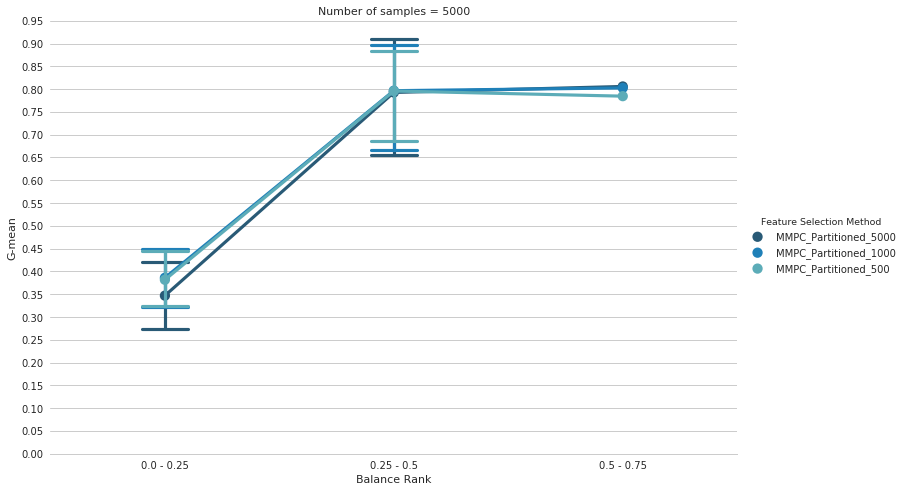

In [632]:
%matplotlib inline
"""
Plotting a three-way ANOVA
==========================

_thumb: .42, .5
"""
import seaborn as sns
sns.set(style="whitegrid")

# Creating the df
df = pd.DataFrame(columns=["Balance Rank", "G-mean","Feature Selection Method","Number of samples"])

# sumarizing data for intervals of 0.25
sumarized_balance_rank=[]
sumarized_balance_rank_2=[]
sumarized_balance_rank_3=[]
ticks_step=0.25
for balance_ticks in np.arange(0.0,0.75,ticks_step):
    sumarized_balance_rank.append([x[2] for x in balance_ranking if x[1]>=balance_ticks and x[1]<balance_ticks+ticks_step])
    sumarized_balance_rank_2.append([x[2] for x in balance_ranking_2 if x[1]>=balance_ticks and x[1]<balance_ticks+ticks_step])
    sumarized_balance_rank_3.append([x[2] for x in balance_ranking_3 if x[1]>=balance_ticks and x[1]<balance_ticks+ticks_step])
        
#     sumarized_balance_rank.append(sum([x[2] for x in balance_ranking if x[1]>=balance_ticks and x[1]<balance_ticks+ticks_step])\
#                                   /len([x[2] for x in balance_ranking if x[1]>=balance_ticks and x[1]<balance_ticks+ticks_step]))
#     sumarized_balance_rank_2.append(sum([x[2] for x in balance_ranking_2 if x[1]>=balance_ticks and x[1]<balance_ticks+ticks_step])\
#                                   /len([x[2] for x in balance_ranking_2 if x[1]>=balance_ticks and x[1]<balance_ticks+ticks_step]))
#     sumarized_balance_rank_3.append(sum([x[2] for x in balance_ranking_3 if x[1]>=balance_ticks and x[1]<balance_ticks+ticks_step])\
#                                   /len([x[2] for x in balance_ranking_3 if x[1]>=balance_ticks and x[1]<balance_ticks+ticks_step]))


for e in sumarized_balance_rank:
    for sub_e in e:
        df = df.append({
             "Balance Rank":str(math.ceil(100*sumarized_balance_rank.index(e)*ticks_step)/100) +
                                ' - ' + 
                            str(math.ceil(100*(sumarized_balance_rank.index(e)*ticks_step+ticks_step))/100), 
            "G-mean":sub_e,
            "Feature Selection Method":'MMPC_Partitioned_5000',
            "Number of samples":5000
              }, ignore_index=True)

for e in sumarized_balance_rank_2:
    for sub_e in e:
        df = df.append({
             "Balance Rank":str(math.ceil(100*sumarized_balance_rank_2.index(e)*ticks_step)/100) +
                            ' - ' + 
                            str(math.ceil(100*(sumarized_balance_rank_2.index(e)*ticks_step+ticks_step))/100), 
            "G-mean":sub_e,
            "Feature Selection Method":'MMPC_Partitioned_1000',
            "Number of samples":5000
              }, ignore_index=True)
    
for e in sumarized_balance_rank_3:
    for sub_e in e:
        df = df.append({
             "Balance Rank":str(math.ceil(100*sumarized_balance_rank_3.index(e)*ticks_step)/100) +
                            ' - ' + 
                            str(math.ceil(100*(sumarized_balance_rank_3.index(e)*ticks_step+ticks_step))/100), 
            "G-mean":sub_e,
            "Feature Selection Method":'MMPC_Partitioned_500',
            "Number of samples":5000
              }, ignore_index=True)


# Draw a pointplot to show pulse as a function of three categorical factors
sns.set_color_codes("pastel")
g = sns.factorplot(x="Balance Rank", y="G-mean", hue="Feature Selection Method",
                   col="Number of samples", data=df,
                   capsize=.2, palette="YlGnBu_d", size=7, aspect=1.5)
g.despine(left=True)

g.set(yticks=np.arange(0.0,1.0,0.05))

In [ ]:
g.savefig("/home/a20114261/GeneInteractions/GeneInteractionsBN/FeatureSelection/MMPC_Partitioned_graph.png")

In [ ]:
for e in sumarized_balance_rank:
    print(e)
for e in sumarized_balance_rank_2:
    print(e)
for e in sumarized_balance_rank_3:
    print(e)

In [ ]:

#%%pycodestyle
def balance_scoring(size1, size2):
    f_size1 = float(size1)
    f_size2 = float(size2)
    if (f_size1/f_size2 <= 1):
        return f_size1/f_size2
    else:
        return f_size2/f_size1

In [ ]:
def CandidateScore(PobDict,TargetEvalNode,intercept_scaling):
    global x_heads_train

    # training and scoring
    X_train_df = pd.read_csv(main_directory+PobDict['dataset'],delimiter='  ',header=None)
    X_train_df.columns=x_heads_train
    
    #X_train, X_test, Y_train, Y_test = train_test_split(X_train_df, X_train_df[TargetEvalNode], test_size=0.1, random_state=0)
    
    X_train = X_train_df
    Y_train = X_train_df[TargetEvalNode]
    
    clf = LinearSVC()
    clf.fit(X_train[PobDict['supercpc']],Y_train)
    
    PobDict['class_precisions']=[]
    for filename in [x for x in os.listdir(main_directory) if x.split('_')[1]==PobDict['dataset'].split('_')[1]]:
        print(len([x for x in os.listdir(main_directory) if x.split('_')[1]==PobDict['dataset'].split('_')[1]]))
        if (filename == PobDict['dataset']):
            continue
        print("*****")
        print()
        print("Testing on dataset: "+filename)
        X_test = pd.read_csv(main_directory+filename,delimiter='  ',header=None)
        X_test.columns = x_heads_train
        

        # get score values
        precision = []
        values_counter=set(X_train_df[TargetEvalNode])
        for val in values_counter:
            #Y_pred_c = clf.predict(X_train_df.query( TargetEvalNode+'== '+str(i))[PobDict['supercpc']][-100:])
            if (len(X_test.query( TargetEvalNode+'== '+str(val)))==0):
                precision.append([val,0,0])
                continue
            Y_pred_c = clf.predict(X_test.query( TargetEvalNode+'== '+str(val))[PobDict['supercpc']])
            precision.append([val,len(Y_pred_c),Y_pred_c.tolist().count(val)/len(Y_pred_c)])

        for e in range(0,len(precision)):
            print('precision for class '+str(precision[e][0])+' with '+str(precision[e][1])+' samples in dataset : '+str(precision[e][2]))
    
        print("G-mean score: "+str(g_mean(precision)))
        print("*****")
        print()
        #print(clf.score(X_test[PobDict['supercpc'][:10]],Y_test))
        PobDict['class_precisions'].append([precision,filename])
    return PobDict

In [ ]:
def g_mean(precision_arr):
    counter=1
    for e in precision_arr:
        counter=counter*e[2]
    
    return counter**(1/len(precision_arr))